In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from keras. utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam 




In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv('DataSets/TATAMOTORS_02_JUN_1991_18_AUG_2024.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-01-02,20.959597,21.857864,20.959597,21.857864,15.690223,0.0
1,1991-01-03,20.959597,21.857864,20.959597,21.857864,15.690223,0.0
2,1991-01-04,21.857864,21.857864,21.857864,21.857864,15.690223,0.0
3,1991-01-07,20.360750,21.259020,20.061329,21.109308,15.152885,0.0
4,1991-01-08,21.109308,21.109308,21.109308,21.109308,15.152885,0.0


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
8454,2024-06-10,977.000000,984.900024,969.099976,975.150024,972.150024,9258931.0
8455,2024-06-11,973.799988,992.549988,966.650024,987.099976,987.099976,14828702.0
8456,2024-06-12,994.500000,1010.250000,987.000000,988.700012,988.700012,17527993.0
8457,2024-06-13,1002.000000,1002.000000,980.750000,985.849976,985.849976,12157226.0
8458,2024-06-14,990.000000,997.250000,981.400024,993.400024,993.400024,11591421.0


In [5]:
df = df.dropna()
df = df[df['Volume']!=0]

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7138 entries, 1178 to 8458
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7138 non-null   object 
 1   Open       7138 non-null   float64
 2   High       7138 non-null   float64
 3   Low        7138 non-null   float64
 4   Close      7138 non-null   float64
 5   Adj Close  7138 non-null   float64
 6   Volume     7138 non-null   float64
dtypes: float64(6), object(1)
memory usage: 446.1+ KB


In [7]:

df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7138.000000,7138.000000,7138.000000,7138.000000,7138.000000,7.138000e+03
mean,211.315819,214.385869,207.818125,210.980768,203.117295,1.519189e+07
std,189.868939,191.860736,187.401432,189.547886,192.250175,2.028181e+07
min,11.114574,11.631977,11.028340,11.267879,9.043228,2.896100e+04
25%,68.815349,70.043875,67.253084,68.680405,52.078042,5.393492e+06
50%,146.844513,149.603004,142.779175,146.544021,132.790619,9.377462e+06
75%,333.562500,337.819389,326.836205,333.070015,330.372642,1.674081e+07
max,1038.000000,1065.599976,1030.400024,1046.650024,1043.430054,3.905778e+08


In [8]:
#Print the shape of Dataframe  and Check for Null Values
print('Dataframe Shape: ', df. shape)
print('Null Value Present: ', df.isnull().values.any())

Dataframe Shape:  (7138, 7)
Null Value Present:  False


<Axes: >

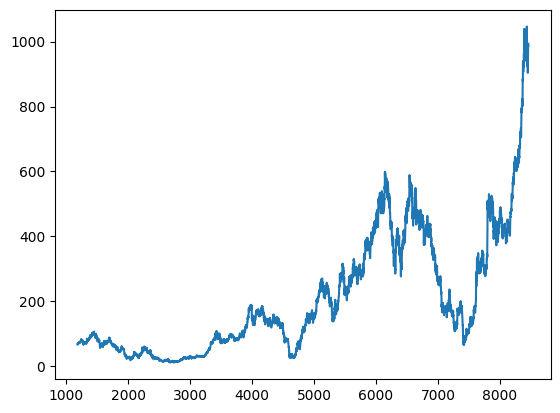

In [9]:
#Plot the Close Value
df['Close'].plot()

In [82]:
#Set Target Variable
output_var = pd.DataFrame(df['Close'])

#Selecting the Feature
features = ['Open', 'Low', 'High', 'Volume']

In [83]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features]) # Scalling 
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index) # Convert to saprate Dataframe 
feature_transform.head()

,Open,Low,High,Volume
1178,0.054491,0.054507,0.052827,0.000951
1180,0.054491,0.054977,0.053736,0.000506
1181,0.055657,0.055917,0.054418,0.000741
1182,0.056357,0.056622,0.056691,0.002931
1183,0.058457,0.057797,0.057145,0.001670


In [84]:
#Splitting to Training set and Test set

timesplit=TimeSeriesSplit(n_splits=5,test_size=int(len(df)*0.2)) # number of split 
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [85]:
# Printing the shape of Training and Test set 
print("Traning shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("Traning Data percentage:", (X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)
print("Test Data percentage:", (X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)


Traning shape: (5711, 4)
Test shape: (1427, 4)
Traning Data percentage: 80.0084057158868
Test Data percentage: 19.991594284113198


In [86]:
#Process the data for LSTM & reshape the data for LSTM to (batch_size, timesteps, input_dim) 

trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

print("Traning shape:", X_train.shape)
print("Test shape:", X_test.shape)

Traning shape: (5711, 1, 4)
Test shape: (1427, 1, 4)


In [87]:

from tensorflow.keras.regularizers import l2


#Building the LSTM Model

lstm = Sequential()
lstm.add(LSTM(units=256, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True, 
            kernel_regularizer=l2(0.001), 
            use_bias=True))

lstm.add(Dropout(0.3))
lstm.add(LSTM(units=128, activation='relu', return_sequences=True))
lstm.add(Dropout(0.3))
# lstm.add(LSTM(units=64, activation='relu', return_sequences=True))
# lstm.add(Dropout(0.3))
# lstm.add(LSTM(units=16, activation='relu', return_sequences=True))
# lstm.add(Dropout(0.3))
lstm.add(Dense(1))

# optimizer = Adam(learning_rate=0.001) 
optimizer = 'adam'

lstm.compile(loss='mean_squared_error', 
             optimizer= optimizer, #'adam',
            )

# plot_model(lstm, show_shapes=True, show_layer_names=True)

lstm.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1, 256)            267264    
                                                                 
 dropout_28 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_29 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_29 (Dropout)        (None, 1, 128)            0         
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 464,513
Trainable params: 464,513
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Model Check Point & Early Stopping

Model_checkpoint_path = "TataMotors_Stock_Price_Prediction.hdf5"

callback = [EarlyStopping(monitor='val_loss', patience = 20, verbose=1),
            ModelCheckpoint(Model_checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')]

In [89]:
with tf.device('GPU'):
    history=lstm.fit(X_train, 
                     y_train, 
                     validation_data=(X_test,y_test),
                     epochs=500, 
                     batch_size=64,
                     verbose=1, 
                     shuffle=False, 
                     callbacks=callback)

Epoch 1/500
90/90 [==============================] - ETA: 0s - loss: 51141.9844
Epoch 1: val_loss improved from inf to 173879.00000, saving model to TataMotors_Stock_Price_Prediction.hdf5
90/90 [==============================] - 5s 42ms/step - loss: 51141.9844 - val_loss: 173879.0000
Epoch 2/500
89/90 [============================>.] - ETA: 0s - loss: 31874.1406
Epoch 2: val_loss improved from 173879.00000 to 75882.57031, saving model to TataMotors_Stock_Price_Prediction.hdf5
90/90 [==============================] - 3s 34ms/step - loss: 31841.8555 - val_loss: 75882.5703
Epoch 3/500
90/90 [==============================] - ETA: 0s - loss: 9263.2480
Epoch 3: val_loss improved from 75882.57031 to 14521.55859, saving model to TataMotors_Stock_Price_Prediction.hdf5
90/90 [==============================] - 3s 29ms/step - loss: 9263.2480 - val_loss: 14521.5586
Epoch 4/500
89/90 [============================>.] - ETA: 0s - loss: 7254.7134
Epoch 4: val_loss improved from 14521.55859 to 5903.853

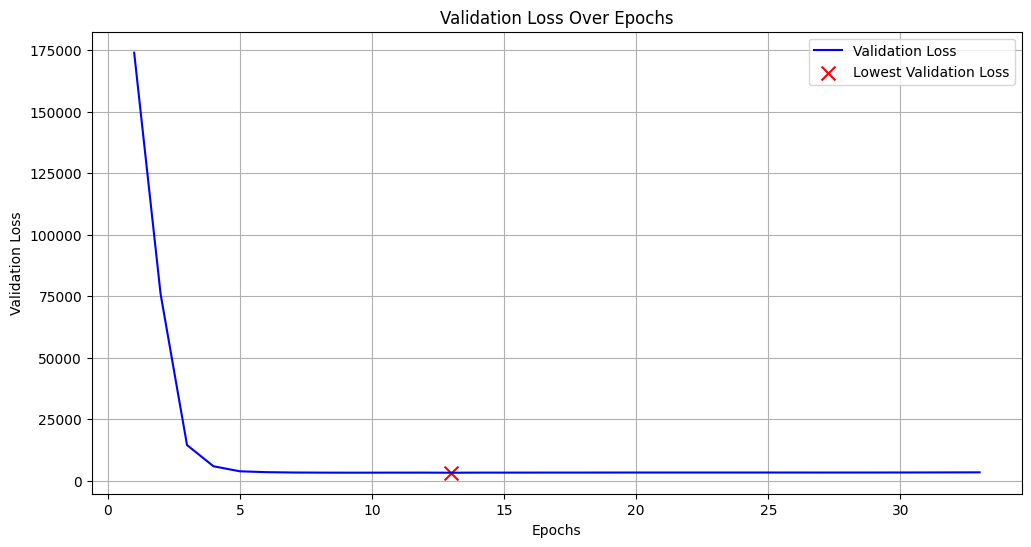

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the history of validation losses
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)

# Find the epoch with the lowest validation loss
min_val_loss = min(val_loss)
min_val_loss_epoch = val_loss.index(min_val_loss) + 1  # +1 because epochs start from 1

# Plotting the validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_loss, label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Epochs')

# Mark the epoch with the lowest validation loss
plt.scatter(min_val_loss_epoch, min_val_loss, color='red', marker='x', s=100, label='Lowest Validation Loss')

plt.legend()
plt.grid(True)
plt.show()


In [91]:
#LSTM Prediction
y_pred= lstm.predict(X_test)
y_pred.shape

45/45 [==============================] - 2s 9ms/step


(1427, 1, 1)

In [92]:

y_pred = y_pred.reshape(-1,1)
y_pred.shape

(1427, 1)

In [93]:
y_test.shape

(1427,)

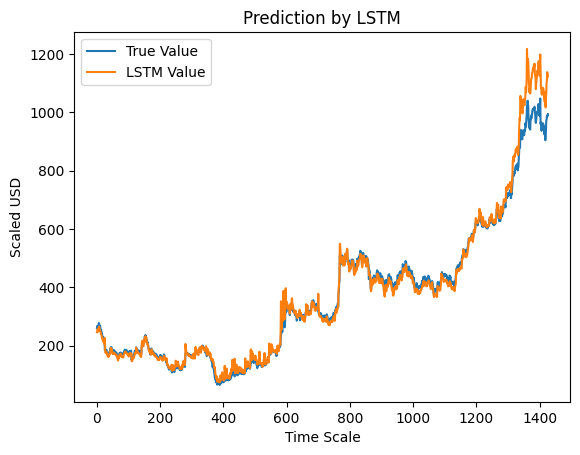

In [94]:
from matplotlib import pyplot as plt

#Predicted vs True Adj Close Value – LSTM

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [95]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and prepare the test data
df_test = pd.read_csv('DataSets/TATAMOTORS_18_JUN_2024_18_AUG_2024.csv')
df_test = df_test.dropna()
df_test = df_test[df_test['Volume'] != 0]

# Select the features and the target
X_test = df_test[['Open', 'Low', 'High', 'Volume']]
y_test = df_test['Close']

# Scale the test features using the same scaler as the training data
X_test_scaled = scaler.transform(X_test)

# Reshape the test data to match the input shape expected by the LSTM model
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Predict the close prices using the LSTM model
predictions = lstm.predict(X_test_scaled, verbose=0)

# Reshape predictions and true values to be 1D arrays
predictions = predictions.flatten()
y_test = y_test.values

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Optional: Print out the first few predictions alongside the actual values
df_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Difference': y_test - predictions
})

print(df_results.head())


Mean Squared Error (MSE): 24433.559818468886
Mean Absolute Error (MAE): 153.0964224670759
       Actual    Predicted  Difference
0  985.900024  1130.516113 -144.616089
1  977.349976  1115.529053 -138.179077
2  978.250000  1107.846680 -129.596680
3  961.799988  1098.944458 -137.144470
4  958.049988  1073.057007 -115.007019


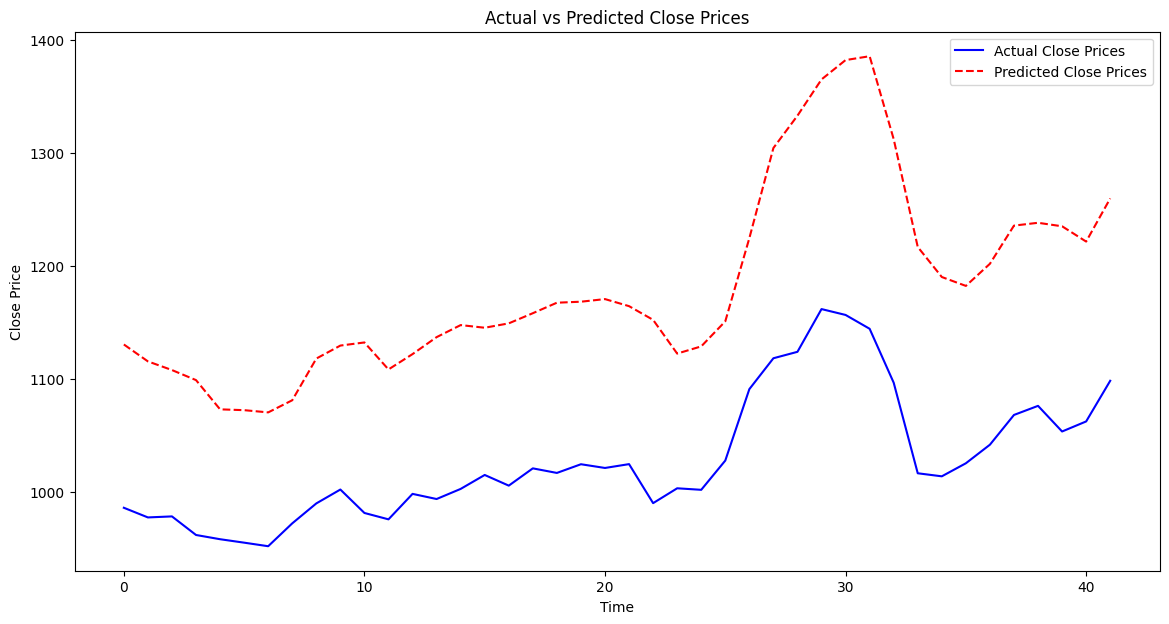

In [96]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted close prices
plt.figure(figsize=(14, 7))
plt.plot(df_test.index, y_test, color='blue', label='Actual Close Prices')
plt.plot(df_test.index, predictions, color='red', linestyle='--', label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [25]:
# lstm.save('TataMotors_Stock_Price_Prediction_3_Diff.h5')